In [39]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 

In [40]:
billing = pd.read_csv("billing.csv") 
events = pd.read_csv("events.csv")
sessions = pd.read_csv("sessions.csv")
users = pd.read_csv('users.csv')
final_expansion_group = pd.read_csv('final_expansion_group.csv')
final_control_group = pd.read_csv('final_control_group.csv')

In [41]:
# 1. Sort by user_id and month
billing = billing.sort_values(["user_id", "month"])
# 2. High-Water Mark: cumulative max per user
billing["max_seats_to_date"] = billing.groupby("user_id")["active_seats"].cummax()
# 3. Previous High-Water Mark: shift within each user’s history
billing["prev_max_seats_to_date"] = billing.groupby("user_id")["max_seats_to_date"].shift()
# 4. True Expansion Month condition
billing["true_expansion_month"] = billing["active_seats"] > billing["prev_max_seats_to_date"]

expansion_events = billing[(billing['user_id'].isin(final_expansion_group['user_id'])) & (billing['true_expansion_month'] == True)]

first_expansion_dates = (
    expansion_events
    .groupby("user_id", as_index=False)
    .agg(first_expansion_month=("month", "min"))
)

# 3. Define pre-expansion window
# If 'month' is stored as a string like 'YYYY-MM', convert to datetime (first day of month)
first_expansion_dates["first_expansion_month"] = pd.to_datetime(first_expansion_dates["first_expansion_month"])
# The pre-expansion window is simply the prior calendar month
first_expansion_dates["pre_expansion_start"] = (first_expansion_dates["first_expansion_month"] - pd.offsets.MonthBegin(1))
first_expansion_dates["pre_expansion_end"]   = (first_expansion_dates["first_expansion_month"] - pd.offsets.MonthEnd(1))


In [42]:
final_control_group['signup_date'] = pd.to_datetime(final_control_group['signup_date'])

first_control_dates = final_control_group[['user_id', 'signup_date']].copy()

# Define observation window
first_control_dates['observation_start'] = first_control_dates['signup_date']
first_control_dates['observation_end']   = first_control_dates['signup_date'] + pd.Timedelta(days=60)

In [43]:
billing

,user_id,month,plan_tier,active_seats,mrr,discount_applied,invoices_overdue,support_ticket_count,max_seats_to_date,prev_max_seats_to_date,true_expansion_month
202639,0000093e-7258-43c0-b212-ea7212795ddf,2024-10,free,1,0.0,0,0,0,1,NaN,False
202640,0000093e-7258-43c0-b212-ea7212795ddf,2024-11,free,1,0.0,0,0,0,1,1.0,False
202641,0000093e-7258-43c0-b212-ea7212795ddf,2024-12,free,1,0.0,0,0,0,1,1.0,False
202642,0000093e-7258-43c0-b212-ea7212795ddf,2025-01,free,3,0.0,0,0,0,3,1.0,True
202643,0000093e-7258-43c0-b212-ea7212795ddf,2025-02,free,4,0.0,0,0,0,4,3.0,True
...,...,...,...,...,...,...,...,...,...,...,...
664545,fffea094-3414-40c4-bab2-3925ba64491d,2025-03,premium,4,48.0,1,0,0,4,NaN,False
664546,fffea094-3414-40c4-bab2-3925ba64491d,2025-04,premium,4,60.0,0,0,0,4,4.0,False
664547,fffea094-3414-40c4-bab2-3925ba64491d,2025-05,premium,3,45.0,0,0,0,4,4.0,False
664548,fffea094-3414-40c4-bab2-3925ba64491d,2025-06,premium,3,45.0,0,0,0,4,4.0,False


In [44]:
first_expansion_dates['group'] = 'expansion'
first_control_dates['group'] = 'control'

In [45]:
# # --- 1. PREP DATA ---

# # Rename control group columns to align with expansion group
# first_control_dates = first_control_dates.rename(columns={
#     "signup_date": "first_expansion_month",
#     "observation_start": "pre_expansion_start",
#     "observation_end": "pre_expansion_end"
# })

# # Merge both groups into a single dataset
# users_to_process = pd.concat([first_expansion_dates, first_control_dates], ignore_index=True)

# # Drop redundant column
# users_to_process = users_to_process.drop(columns=['first_expansion_month'])
# sessions['session_start']=pd.to_datetime(sessions['session_start'])
# sessions['session_end']= pd.to_datetime(sessions['session_end'])
# events['ts'] = pd.to_datetime(events['ts'])
# billing['month'] = pd.to_datetime(billing['month'])


# # --- 2. DEFINE PRODUCT FEATURES ---

# PRODUCT_FEATURES = [
#     'jira_board', 'jira_automation', 'team_invite', 'bitbucket_integration',
#     'confluence_page', 'confluence_ai_assist', 'trello_export_csv'
# ]

# # --- 3. FEATURE ENGINEERING FUNCTION ---

# def calculate_features_for_user(user_id, window_start, window_end, group):
#     """
#     Calculates behavioral features for a single user
#     within the specified time window.
#     """
    
#     # Filter data
#     user_sessions = sessions[
#         (sessions['user_id'] == user_id) &
#         (sessions['session_start'].between(window_start, window_end))
#     ]
#     user_events = events[
#         (events['user_id'] == user_id) &
#         (events['ts'].between(window_start, window_end))
#     ]
#     user_billing = billing[
#         (billing['user_id'] == user_id) &
#         (billing['month'].between(window_start, window_end))
#     ]

#     results = {
#         'user_id': user_id,
#         'group': group
#     }

#     # --- A) Usage Cadence & Intensity ---
#     session_count = len(user_sessions)
#     results['session_count'] = session_count
#     results['total_usage_seconds'] = user_sessions['session_length_sec'].sum()
#     results['avg_session_length'] = (
#         user_sessions['session_length_sec'].mean() if session_count > 0 else 0
#     )
#     results['active_days'] = user_sessions['session_start'].dt.date.nunique()
#     results['most_used_device'] = (
#         user_sessions['device'].mode()[0] if not user_sessions.empty else None
#     )

#     # --- B) Product Engagement ---
#     results['total_events'] = len(user_events)
#     results['avg_latency'] = user_events['latency_ms'].mean()
#     results['error_rate'] = (
#         user_events[user_events['success'] == False].shape[0] / len(user_events)
#         if not user_events.empty else 0
#     )

#     adopted_feature_count = 0
#     for feature in PRODUCT_FEATURES:
#         feature_events = user_events[user_events['feature_name'] == feature]
#         used_feature_flag = 1 if not feature_events.empty else 0
#         results[f'used_{feature}'] = used_feature_flag
#         results[f'{feature}_event_count'] = len(feature_events)
#         adopted_feature_count += used_feature_flag

#     results['feature_adoption_count'] = adopted_feature_count
#     results['used_core_jira_suite'] = (
#         1 if results['used_jira_board'] and results['used_jira_automation'] else 0
#     )
#     results['used_core_confluence_suite'] = (
#         1 if results['used_confluence_page'] and results['used_confluence_ai_assist'] else 0
#     )
#     results['used_any_integration'] = (
#         1 if results['used_bitbucket_integration'] or results['used_trello_export_csv'] else 0
#     )

#     # --- C) Billing & Health ---
#     results['support_ticket_count'] = user_billing['support_ticket_count'].sum()
#     results['had_overdue_invoice'] = 1 if user_billing['invoices_overdue'].any() else 0
    
#     return results

# # --- 4. PROCESS USERS ---

# print(f"Starting feature engineering for {len(users_to_process)} users...")

# analysis_data = []
# for i, row in enumerate(users_to_process.itertuples(), start=1):
#     # FIX: use the renamed columns
#     result = calculate_features_for_user(
#         row.user_id,
#         row.pre_expansion_start,
#         row.pre_expansion_end,
#         row.group
#     )
#     analysis_data.append(result)
    
#     if i % 100 == 0 or i == len(users_to_process):
#         print(f"Processed {i}/{len(users_to_process)} users...")

# print("Feature engineering complete.")

# # --- 5. FINAL DATASET ---

# final_analysis_df = pd.DataFrame(analysis_data)
# final_analysis_df.to_csv('final_analysis_dataset.csv', index=False)

# print("\nFinal analysis DataFrame created and saved to 'final_analysis_dataset.csv'")
# print(f"Shape of the final DataFrame: {final_analysis_df.shape}")
# print("\nFirst 5 rows:")
# print(final_analysis_df.head())


In [46]:

# --- 1) SESSIONS AGGREGATES ---------------------------------------------------

# Preping other factors values
sessions['session_start'] = pd.to_datetime(sessions['session_start'], errors='coerce')
sessions['session_end']   = pd.to_datetime(sessions['session_end'], errors='coerce')
events['ts']              = pd.to_datetime(events['ts'], errors='coerce')
billing['month']          = pd.to_datetime(billing['month'], errors='coerce').dt.to_period('M')
# --- 0) FAST PREP -------------------------------------------------------------
# helpful dtype downsizing
for col in ['user_id', 'device', 'feature_name', 'group']:
    for df in (sessions, events, billing,):
        if col in df.columns:
            df[col] = df[col].astype('category')

# DF Containing both group: a single row per user with window and group
U = (pd.concat([first_expansion_dates, 
                first_control_dates.rename(columns={
                    "signup_date": "first_expansion_month",
                    "observation_start": "pre_expansion_start",
                    "observation_end": "pre_expansion_end"
                })], ignore_index=True)
       .drop(columns=['first_expansion_month'])
       .set_index('user_id')
       .astype({'group': 'category'}))

U['start_m'] = U['pre_expansion_start'].dt.to_period('M')
U['end_m']   = U['pre_expansion_end'].dt.to_period('M')

S = sessions.merge(U[['pre_expansion_start','pre_expansion_end']], 
                   left_on='user_id', right_index=True, how='inner')
S = S[(S['session_start'] >= S['pre_expansion_start']) & 
      (S['session_start'] <= S['pre_expansion_end'])]

# active days without Python loops
S['session_day'] = S['session_start'].dt.normalize()

sessions_agg = S.groupby('user_id').agg(
    session_count=('session_id', 'size'),
    total_usage_seconds=('session_length_sec', 'sum'),
    avg_session_length=('session_length_sec', 'mean'),
    active_days=('session_day', 'nunique')
)

# most_used_device (fast “mode”)
device_counts = (S.groupby(['user_id','device']).size()
                   .rename('n')
                   .reset_index())
device_mode = (device_counts.sort_values(['user_id','n','device'], 
                                          ascending=[True, False, True])
                           .drop_duplicates('user_id')
                           .set_index('user_id')['device'])

sessions_agg['most_used_device'] = device_mode
sessions_agg['avg_session_length'] = sessions_agg['avg_session_length'].fillna(0)

# --- 2) EVENTS AGGREGATES & FEATURE FLAGS ------------------------------------
E = events.merge(U[['pre_expansion_start','pre_expansion_end']], 
                 left_on='user_id', right_index=True, how='inner')
E = E[(E['ts'] >= E['pre_expansion_start']) & (E['ts'] <= E['pre_expansion_end'])]

events_agg = E.groupby('user_id').agg(
    total_events=('event_id', 'size'),
    avg_latency=('latency_ms', 'mean'),
    error_rate=('success', lambda s: (s == 0).mean())  # success is 0/1 per your info()
)

# feature usage counts in wide form
PRODUCT_FEATURES = [
    'jira_board','jira_automation','team_invite','bitbucket_integration',
    'confluence_page','confluence_ai_assist','trello_export_csv'
]

feat_counts = (E[E['feature_name'].isin(PRODUCT_FEATURES)]
                 .groupby(['user_id','feature_name']).size()
                 .unstack(fill_value=0)
                 .reindex(columns=PRODUCT_FEATURES, fill_value=0))

used_flags = (feat_counts > 0).astype('uint8')
used_flags.columns = [f'used_{c}' for c in used_flags.columns]

feat_event_counts = feat_counts.copy()
feat_event_counts.columns = [f'{c}_event_count' for c in feat_event_counts.columns]

feature_adoption_count = used_flags.sum(axis=1).astype('uint8').rename('feature_adoption_count')

used_core_jira_suite = ((used_flags.get('used_jira_board', 0) & 
                         used_flags.get('used_jira_automation', 0))
                        .astype('uint8').rename('used_core_jira_suite'))

used_core_confluence_suite = ((used_flags.get('used_confluence_page', 0) & 
                               used_flags.get('used_confluence_ai_assist', 0))
                              .astype('uint8').rename('used_core_confluence_suite'))

used_any_integration = ((used_flags.get('used_bitbucket_integration', 0) | 
                         used_flags.get('used_trello_export_csv', 0))
                        .astype('uint8').rename('used_any_integration'))

# --- 3) BILLING AGGREGATES ----------------------------------------------------
B = billing.merge(U[['start_m','end_m']], 
                  left_on='user_id', right_index=True, how='inner')
B = B[B['month'].between(B['start_m'], B['end_m'], inclusive='both')]

billing_agg = B.groupby('user_id').agg(
    support_ticket_count=('support_ticket_count', 'sum'),
    had_overdue_invoice=('invoices_overdue', lambda s: int((s > 0).any()))
)

# --- 4) COMBINE EVERYTHING ----------------------------------------------------
final = (U[['group']]
         .join(sessions_agg, how='left')
         .join(events_agg,   how='left')
         .join([feat_event_counts, used_flags,
                feature_adoption_count, 
                used_core_jira_suite,
                used_core_confluence_suite,
                used_any_integration], how='left')
         .join(billing_agg,  how='left'))

# fill NaNs produced by users with no activity in a table
num_cols = final.select_dtypes(include=['float64','int64','uint8']).columns
final[num_cols] = final[num_cols].fillna(0)

final_analysis_df = final.reset_index()
final_analysis_df.to_csv('final_analysis_dataset.csv', index=False)

print("Shape:", final_analysis_df.shape)


/tmp/ipykernel_16162/3248589792.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  device_counts = (S.groupby(['user_id','device']).size()
/tmp/ipykernel_16162/3248589792.py:74: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['user_id','feature_name']).size()


Shape: (39298, 30)


In [47]:
final_analysis_df

,user_id,group,session_count,total_usage_seconds,avg_session_length,active_days,most_used_device,total_events,avg_latency,error_rate,...,used_bitbucket_integration,used_confluence_page,used_confluence_ai_assist,used_trello_export_csv,feature_adoption_count,used_core_jira_suite,used_core_confluence_suite,used_any_integration,support_ticket_count,had_overdue_invoice
0,000f0003-fbcc-4375-a9d6-1d8c63dbdf05,expansion,1.0,394.0,394.000000,1.0,desktop,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,001152fb-e29a-4cf5-878c-901af2268ad0,expansion,0.0,0.0,0.000000,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2,001281b3-e61d-45e0-8551-68da908a2edf,expansion,1.0,1062.0,1062.000000,1.0,web,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
3,0012a970-074a-4701-b157-207958ab299c,expansion,0.0,0.0,0.000000,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4,001a825f-72d1-4b7f-a2f5-f14cb5bc0714,expansion,0.0,0.0,0.000000,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39293,271d311a-49d5-45a4-abc2-b05b189e5f38,control,3.0,1240.0,413.333333,3.0,mobile,3.0,126.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1,0
39294,8906fae6-a894-4874-9bb2-4f3493219ce4,control,1.0,915.0,915.000000,1.0,web,2.0,268.5,0.5,...,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,3,0
39295,e34dbe71-5343-415b-84c3-7d01751704f9,control,0.0,0.0,0.000000,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
39296,17475b9e-2885-4ba1-97f8-5c32335c5419,control,0.0,0.0,0.000000,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


In [ ]:
first_control_dates.columns

Index(['user_id', 'signup_date', 'observation_start', 'observation_end',
       'group'],
      dtype='object')

In [49]:
final_analysis_df.to_csv('expansion_analysis_df.csv', index = False)

In [55]:
# Load your user data with signup dates
users = pd.read_csv('users.csv', parse_dates=['signup_date'])
users['signup_month'] = users['signup_date'].dt.to_period('M')

# Load your expansion dates
# first_expansion_dates = pd.read_csv('first_expansion_dates.csv') # Assuming month is a string like '2024-05'
#first_expansion_dates['first_expansion_month'] = pd.to_datetime(first_expansion_dates['first_expansion_month']).dt.to_period('M')

# Merge them
diagnostic_df = pd.merge(first_expansion_dates, users[['user_id', 'signup_date', 'signup_month']], on='user_id')

# The smoking gun:
same_month_expansions = diagnostic_df[diagnostic_df['first_expansion_month'] == diagnostic_df['signup_month']]

print(f"Total expansions analyzed: {len(diagnostic_df)}")
print(f"Expansions that happened in the signup month: {len(same_month_expansions)}")
print(f"Percentage with flawed window: {100 * len(same_month_expansions) / len(diagnostic_df):.2f}%")

Total expansions analyzed: 19649
Expansions that happened in the signup month: 0
Percentage with flawed window: 0.00%


--- Signup Month Distribution by Group ---
group        control  expansion
signup_date                    
2024-02          583        583
2024-03          617        617
2024-04          669        669
2024-05          702        702
2024-06          697        697
2024-07          829        829
2024-08          865        865
2024-09          928        928
2024-10         1065       1065
2024-11         1068       1068
2024-12         1235       1235
2025-01         1303       1303
2025-02         1411       1411
2025-03         1679       1679
2025-04         1886       1886
2025-05         2247       2247
2025-06         1865       1865


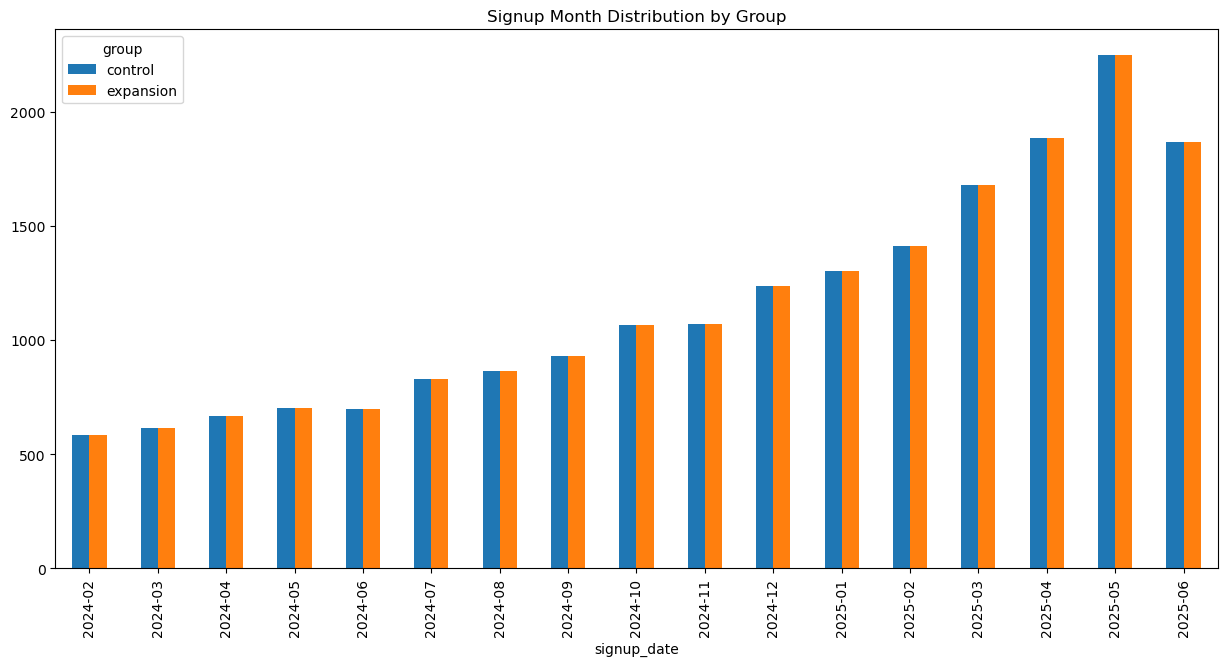

In [ ]:
# # Load necessary files
# users = pd.read_csv('users.csv', parse_dates=['signup_date'])
# final_analysis_df = pd.read_csv('expansion_analysis_df.csv')

# # Get the signup dates for the users in your final analysis
# users_in_analysis = users[users['user_id'].isin(final_analysis_df['user_id'])]

# # Merge to bring the 'group' column alongside the signup_date
# analysis_info = final_analysis_df[['user_id', 'group']]
# diagnostic_df = pd.merge(users_in_analysis, analysis_info, on='user_id')

# # Now, compare the distribution of signup months
# signup_distribution = pd.crosstab(diagnostic_df['signup_date'].dt.to_period('M'), diagnostic_df['group'])

# print("--- Signup Month Distribution by Group ---")
# print(signup_distribution)

# # Visualize it
# signup_distribution.plot(kind='bar', figsize=(15, 7), title='Signup Month Distribution by Group')
# plt.show()